# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach.

There are four parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, and 4) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp.

__Sinusoidal modeling and sine tracking:__
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking.

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time.
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies.

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid.

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` should estimate the frequency of a sinusoidal signal at a given time instant. The function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`.

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [1]:
import numpy as np
from scipy.signal import get_window
import math
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from smstools.models import stft
from smstools.models import sineModel as SM
import IPython.display as ipd

In [4]:
# E5 - 1.1: Complete the function min_freq_est_err()

def min_freq_est_err(input_file, f):
    """Best estimate the frequency of a sinusoid by iterating over different sizes of analysis window.

    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)

    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
            M (int): Window size
            N (int): FFT size

    """
    #delta = |f - f_est| < 0.05 Hz
    # analysis parameters:
    window = 'blackman' #main lobe: 6 bins
    t = -40 #threshold to get peaks
    (fs,x) = UF.wavread(input_file)
    k = 1
    delta = 1
    while delta >= 0.05:
        M = 100*k +1 
        N = 2 ** int(np.ceil(np.log2(M))) 
        w = get_window(window, M)
        center_idx = int(0.5 * fs)
        hM = M // 2
        x1 = x[center_idx-hM:center_idx+hM+1]
        mX, pX = DFT.dftAnal(x1, w, N)
        ploc = UF.peakDetection(mX,t) #ploc is the location
        if len(ploc) == 0:
           k += 1
           continue
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)
        #f_est = iploc*(fs / N)  # convert bin index to Hz
        f_est = fs * iploc / float(N)
        #print(M, N, f_est)
    #to get the distance between two samples i can do : fs/fft size

        delta = abs(f - f_est).item()
        k += 1



    return f_est, M, N




Test cases for `min_freq_est_err()`:

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the frequency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the frequency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the frequency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [5]:
# E5 - 1.2: 
# For each of the 3 test cases, play the input sinusoid, call the function min_freq_est_err(),
# generate sinusoid with estimated frequency value, and play it. Explain the result.
import matplotlib.pyplot as plt
import IPython.display as ipd
#TEST CASE 1
input_file1 = '../sounds/sine-490.wav'
f1 = 490
f_est1, M1, N1 = min_freq_est_err(input_file1, f1)
fs, x1 = UF.wavread(input_file1)  
y1 = np.sin(2 * np.pi * f_est1 * np.arange(len(x1)) / fs)
print("Test Case 1:")
print(f_est1, M1, N1)
ipd.display(ipd.Audio(data=x1, rate=fs))
ipd.display(ipd.Audio(data=y1, rate=fs))


# TEST CASE 2
input_file2 = '../sounds/sine-1000.wav'
f2 = 1000
f_est2, M2, N2 = min_freq_est_err(input_file2, f2)
fs, x2 = UF.wavread(input_file2)  
y2 = np.sin(2 * np.pi * f_est2 * np.arange(len(x2)) / fs)
print("Test Case 2:")
print(f_est2, M2, N2)
ipd.display(ipd.Audio(data=x2, rate=fs))
ipd.display(ipd.Audio(data=y2, rate=fs))

# TEST CASE 3
input_file3 = '../sounds/sine-200.wav'
f3 = 200
f_est3, M3, N3 = min_freq_est_err(input_file3, f3)
fs, x3 = UF.wavread(input_file3)  
y3 = np.sin(2 * np.pi * f_est3 * np.arange(len(x3)) / fs)
print("Test Case 3:")
print(f_est3, M3, N3)
ipd.display(ipd.Audio(data=x3, rate=fs))
ipd.display(ipd.Audio(data=y3, rate=fs))



Test Case 1:
[489.9630183] 1101 2048


Test Case 2:
[1000.01994268] 1101 2048


Test Case 3:
[200.03811968] 1201 2048


**Question  E5 - 1.2:**

#### Explain the results of  1.1
------
The results sound very identical to the original signals. The error <2 Hz is so small, that a typical human JND for pitch could not recognize the difference. For low frequencies (below 500 hz), the JND is about 3 Hz for sine waves and for higher frequencies (above 1000 Hz), the JND for sine waves is about 0.6% of the frequency (approx. 10 cents) which was not exceeded in these examples.

## Part 2 - Tracking a two component chirp

In this part you should perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`.

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz.

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`.

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram.

In [2]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given signal length and sampling rate.

    Args:
        xlen (int): duration of signal in samples
        M (int): window size
        fs (int): sampling rate
        H (int): hop size

    Result:
        np.array: time stamps

    """
    hM1 = int(np.floor((M+1)/2))
    hM2 = int(np.floor(M/2))
    xlen = xlen + 2*hM2 #zeropadding left and right for the first and last samples
    pin = hM1
    pend = xlen - hM1 #for last sample analysis
    tStamps = np.arange(pin,pend,H)/float(fs) #Creates a list of sample indices starting at pin, ending before pend, spaced every H samples
    return tStamps
#time = samples / sampling rate
#returns time stamps for each windows' center

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound

    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples

   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component

    """

    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation

    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)

    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M` should be chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks shouldd be done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values.

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669, 528.533]` Hz, which as you can see do not give us the desired estimation errors.

Mean errors for M = 1023 : [ 13.66932655 528.5333854 ] Hz
Mean errors for M = 6616 : [10.20918393 28.3468712 ] Hz
Mean errors for M = 4000 : [0.7256747  1.32189126] Hz


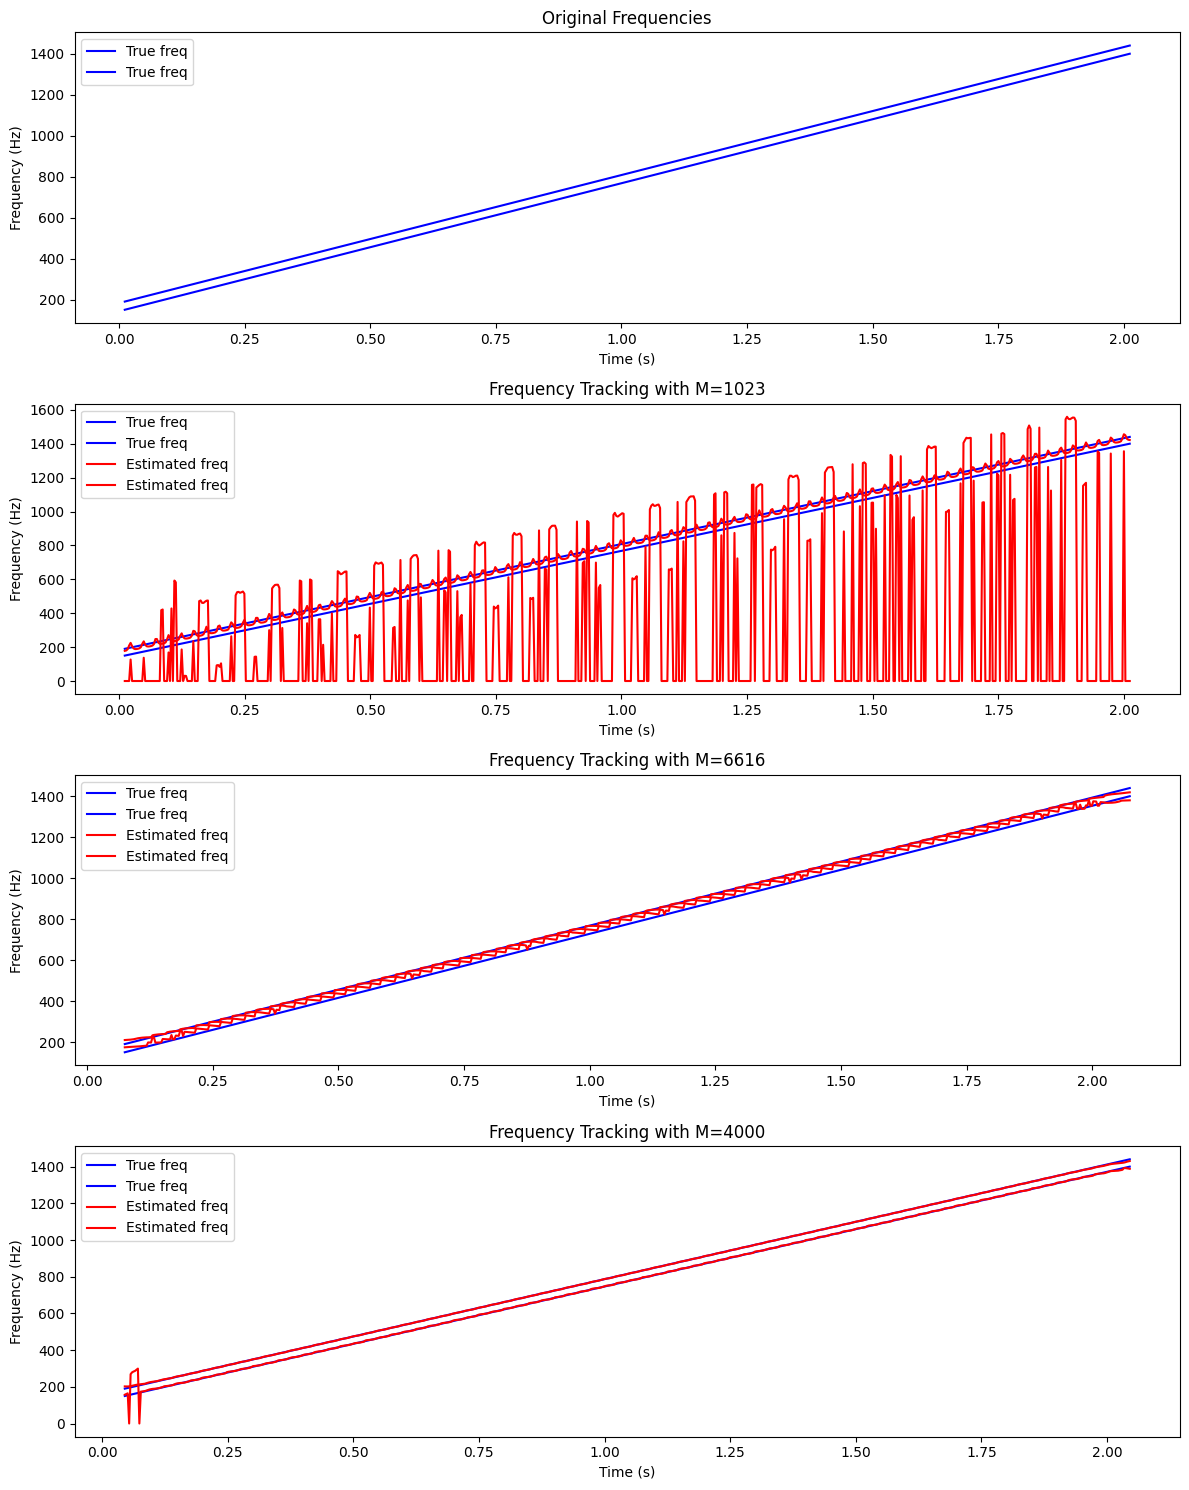

In [5]:
# E5 - 2.1: 
# First call function freq_tracker_error() with the test case values and plot the true versus the
# estimated frequency values, then change the window-size to obtain minimum possible error, and plot the new
# estimated frequency values. Explain the choice and result.

import matplotlib.pyplot as plt

H = 128
window = 'blackman'
t = -80
#TEST CASE
M1 = 1023 
input_file = '../sounds/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file)
tStamps1 = gen_time_stamps(x.size, M1, fs, H)   # Generate the tStamps to return
fTrackTrue1 = gen_true_freq_tracks_chirp_150_190(tStamps1)
meanErr1, fTrackEst1 = freq_tracker_error(input_file, fTrackTrue1, window, t, H, M1)
print(f"Mean errors for M = 1023 : {meanErr1} Hz")

#FIRST TRIAL
M2 = 6615
tStamps2 = gen_time_stamps(x.size, M2, fs, H)   # Generate the tStamps to return
fTrackTrue2 = gen_true_freq_tracks_chirp_150_190(tStamps2)
meanErr2, fTrackEst2 = freq_tracker_error(input_file, fTrackTrue2, window, t, H, M2)

print(f"Mean errors for M = 6616 : {meanErr2} Hz")

#SECOND TRIAL
M3 = 4001 
tStamps3 = gen_time_stamps(x.size, M3, fs, H)   # Generate the tStamps to return
fTrackTrue3 = gen_true_freq_tracks_chirp_150_190(tStamps3)
meanErr3, fTrackEst3 = freq_tracker_error(input_file, fTrackTrue3, window, t, H, M3)

print(f"Mean errors for M = 4000 : {meanErr3} Hz")

# Plot test case
plt.figure(1, figsize=(12, 15))
plt.subplot(411)
plt.plot(tStamps1, fTrackTrue1, 'b', label='True freq')
plt.title('Original Frequencies')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.subplot(412)
plt.plot(tStamps1, fTrackTrue1, 'b', label='True freq')
plt.plot(tStamps1, fTrackEst1, 'r', label='Estimated freq')
plt.title('Frequency Tracking with M=1023')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.subplot(413)
plt.plot(tStamps2, fTrackTrue2, 'b', label='True freq')
plt.plot(tStamps2, fTrackEst2, 'r', label='Estimated freq')
plt.title('Frequency Tracking with M=6616')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.subplot(414)
plt.plot(tStamps3, fTrackTrue3, 'b', label='True freq')
plt.plot(tStamps3, fTrackEst3, 'r', label='Estimated freq')
plt.title('Frequency Tracking with M=4000')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.tight_layout()
plt.show()  
    



**Question  E5 - 2.2:**

#### Explain the results of  2.1
------
Based on the theoretical formula, we have M > = Bs * fs / Δ, where Bs is the width of the main lobe (in bins), fs is the sampling rate and Δ is the minimum frequency seperation we want to distinguish.

In our case, we have blackman window which has a main-lobe width of approximately 6 bins, and we want to distinguish between two chirping sinusoids with frequency seperation Δ = 190-150=40 Hz. The minimum size is M = 6 * 44100 / 40 = 6615.  But that M choice doesn't produce good results, because it can't capture accurately frequencies change over time. We want a window size that captures for each frame the frequency change.

This window size provides the minimum required length to separate the two sinusoids if their frequencies were constant. However, since the signals are chirps, using such a large window is problematic. A large window improves frequency resolution but reduces time resolution, meaning rapid changes in frequency are smeared or averaged across the window.

To effectively track the frequency evolution of the chirps, we need a compromise: a medium-sized window that provides sufficient frequency resolution to distinguish the two components while maintaining enough time resolution to follow their variation over time.

For that reason, this means starting from the theoretical value (M=6615) and gradually decreasing the window size until we find a good balance between time and frequency resolution is achieved. Good results were noticed for M = 4001.

## Part 3 -Tracking sinusoids of different amplitudes

In this part you should perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`.

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`.

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`.

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid.

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'hanning'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz.


Mean errors for test case values : [ 0.19603701 29.51140584] Hz
Mean errors for optimal values : [0.03843794 0.06193919] Hz


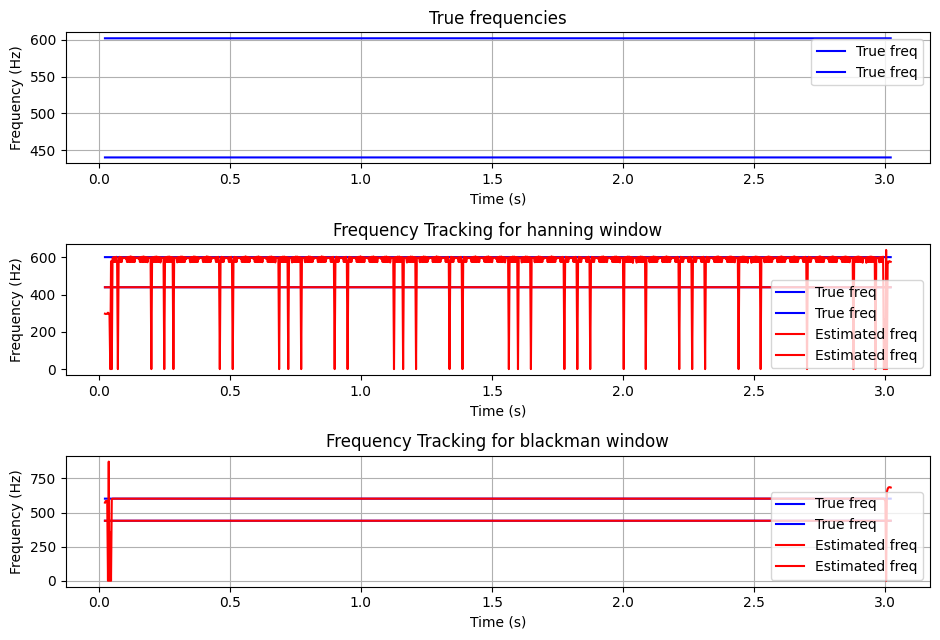

In [7]:
# E5 - 3.1: 
# First call freq_tracker_error() with the values for the test case and plot the true versus the
# estimated frequency values. Then choose the window and threshold to obtain minimum possible error, and plot
# the new estimated frequency values. Explain the result.
import matplotlib.pyplot as plt
M = 2047                                             # Window size
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

### Your code here
#Test case
window = 'hann'
t = -80.0
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

print(f"Mean errors for test case values : {meanErr} Hz")

#Chosen values
window1 = 'blackmanharris'
t1 = -70.0
meanErr1, fTrackEst1 = freq_tracker_error(input_file, fTrackTrue, window1, t1, H, M)

print(f"Mean errors for optimal values : {meanErr1} Hz")

# Plots
plt.figure(1, figsize=(9.5, 6.5))
plt.subplot(311)
plt.plot(tStamps, fTrackTrue, 'b', label='True freq')
plt.title('True frequencies')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.subplot(312)
plt.plot(tStamps, fTrackTrue, 'b', label='True freq')
plt.plot(tStamps, fTrackEst, 'r', label='Estimated freq')
plt.title('Frequency Tracking for hanning window')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.subplot(313)
plt.plot(tStamps, fTrackTrue, 'b', label='True freq')
plt.plot(tStamps, fTrackEst1, 'r', label='Estimated freq')
plt.title('Frequency Tracking for blackman window')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Question  E5 - 3.2:**

#### Explain the results of 3.1
------
Since one of the signals has very low amplitude, we have to be careful so that the side-lobes of the window don't interfere with the magnitude of the signal. That's why we have to choose a window with low side-lobes magnitude. For the signal with low amplitude we get in dB : m =20log10​(0.002) = -54 dB.

Based on that, two choices we could use are blackman  with side lobes dB = -58 dB and blackman harris with side lobes -92 dB. Blackman window's side lobes amplitude is very close to the sinusoid's so for safety we choose blackman harris.

The threshold value t should be set above the window sidelobes and below the weakest signal component. In this case, we select a value between the two limits, choosing t=−70 dB.


## Part 4 - Sinusoidal modeling of a multicomponent signal

In this part you will perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found.

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram.

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.


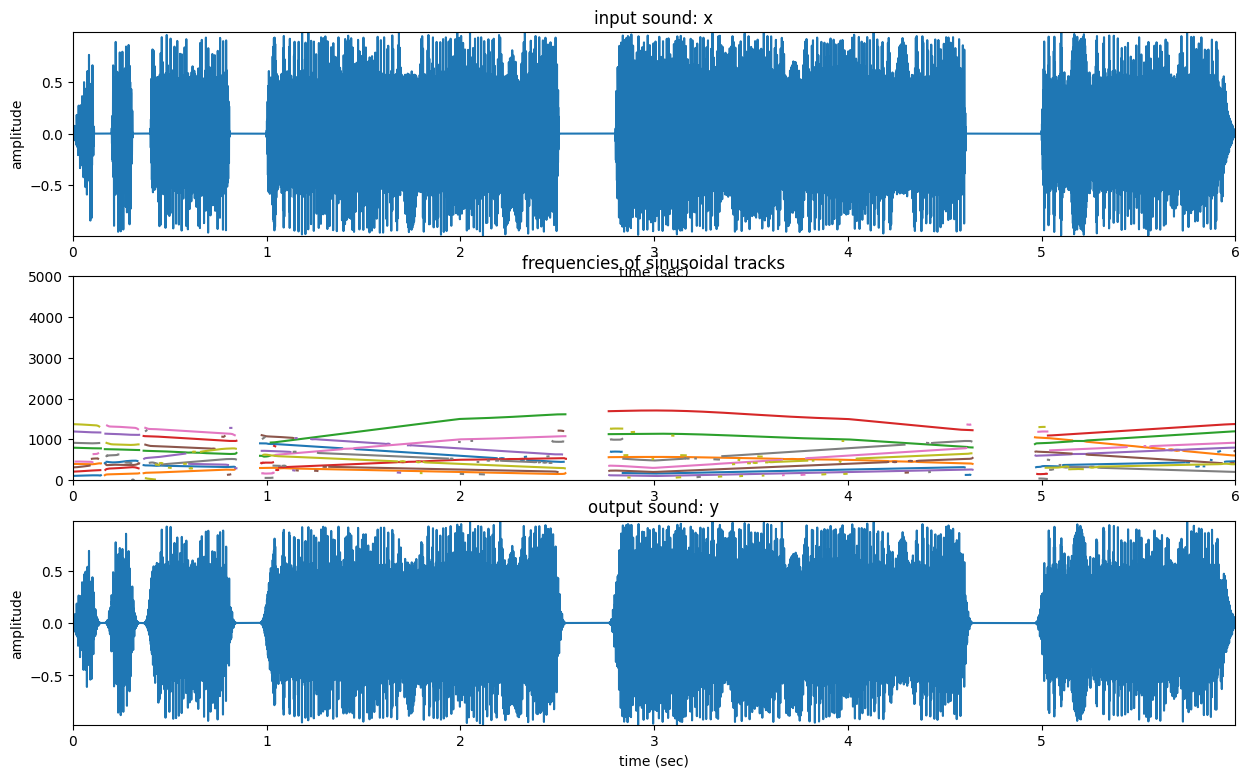

In [8]:
# E5 - 4.1: 
# Set the analysis parameters of sineModelAnal() to perform the best analysis of multiSines.wav

import IPython.display as ipd

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'blackman'
M = 4000
N = int(2 ** np.ceil(np.log2(M)))
t = -80
minSineDur = 0.0
maxnSines = 9
freqDevOffset = 20
freqDevSlope = 0.001


# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)

fs, x = UF.wavread(input_file)               # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Question  E5 - 4.2:**

#### Explain the results of Part 4
------
By examining the spectrogram in Sonic Visualizer using a Blackman window with M = 4096, we observed a maximum of 9 simultaneous sinusoids,  so we set maxnSines = 9.

For the analysis window, we chose a Blackman window, because we wanted a window with very good side-lobe suppression. While the Blackman-Harris window offers even stronger side-lobe suppression (~93 dB), the Blackman window (~58 dB) was selected because it has a sharper main lobe, providing better frequency localization while still maintaining sufficiently low side-lobe levels to reduce interference between closely spaced frequency components.

The window size M = 4096 was chosen by balancing frequency and time resolution requirements. We wanted to pick a M large enough for frequency spacing and chirp deviation, but not too large to lose short transients.

The FFT size N was set to the next power of 2 greater than M: N = int(2^⌈log₂(M)⌉). 

The magnitude threshold t = -80 dB was selected by comparing the signal amplitudes with the window's side-lobe levels in Sonic Visualizer's spectrum. 

minSineDur = 0.0 was set to disable duration filtering entirely. This ensures that all detected peaks are considered, including rapid transients and short chirps, allowing the analysis to retain the full spectral content of the signal. While this may include some spurious peaks from noise, it helps capturing the brief spectral events present in the audio.

Finally, freqDevOffset = 20 Hz and freqDevSlope = 0.001 were chosen to allow tracking flexibility. Since the signal includes chirps and frequency crossings, these parameters permit sinusoidal tracks to deviate moderately in frequency between frames, enabling the continuation of time-varying components.





